# Model Training and Testing for the "Utilitarian" Dataset

## Loading the dataset

In [ ]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import tensorflow
import keras
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, cross_validate, RandomizedSearchCV
import logging
import warnings
import matplotlib.pyplot as plt
from matplotlib import patches
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import seaborn as sns
from sklearn.inspection import permutation_importance
import joblib

2024-12-02 10:02:22.150894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
# Load in the training and test datasets
X_trainval_utilitarian = pd.read_csv('Data/X_trainval_utilitarian.csv')
y_trainval_utilitarian = pd.read_csv('Data/y_trainval_utilitarian.csv').values.ravel() # ravel to convert to 1D array
X_test_utilitarian = pd.read_csv('Data/X_test_utilitarian.csv')
y_test_utilitarian = pd.read_csv('Data/y_test_utilitarian.csv').values.ravel() # ravel to convert to 1D array

In [30]:
pd.set_option('display.max_columns', None)
X_trainval_utilitarian.head()

,PedPed,Barrier,NumberOfCharacters,DiffNumberOFCharacters,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,NumberOfLivesSaved,Finance_nols,ICT_nols,Industry_nols,Overall_nols,Research_nols,Skills_nols,Total_nols,Males_nols,Females_nols,Passengers_nols,Pedestrians_nols,AttributeLevel_More,CrossingSignal_1,CrossingSignal_2,Clusters_1,Clusters_2,Clusters_3,Clusters_4,Clusters_5
0,1,0,0.845076,-0.449067,1.894694,-0.436605,-0.437006,-0.437964,1.898027,-0.437596,-0.437237,-0.437748,-0.437297,-0.437018,4.223434,-0.437762,-0.437169,1.889421,-0.43736,-0.437544,-0.436515,-0.436645,-0.438072,-0.438222,0.807870,-0.203868,0.065141,1.001200,1.240846,0.192654,0.682665,0.514950,1.143918,0.438905,0.285340,0.729522,0.797722,0.690334,0.730503,0.834899,0.952693,0.742719,0.880342,0.819175,1.033383,0.796188,0.721639,1,0,0,0,1,0,0,0
1,0,0,0.845076,1.339690,-0.437400,-0.436605,-0.437006,-0.437964,-0.436789,-0.437596,1.894088,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,1.901005,4.225389,1.899310,-0.438222,0.807870,-0.203868,0.065141,1.001200,1.240846,0.192654,0.682665,0.514950,1.143918,0.438905,0.285340,1.459301,1.595665,1.380825,1.461203,1.669956,1.905463,1.485694,1.760934,1.638626,2.066930,1.592637,1.443514,1,0,0,0,1,0,0,0
2,1,0,0.169392,-1.343446,-0.437400,-0.436605,-0.437006,-0.437964,-0.436789,1.894391,1.894088,-0.437748,1.900932,-0.437018,1.893286,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,-0.436645,-0.438072,-0.438222,-0.161656,0.996578,1.257895,0.269309,0.301359,0.192654,-0.946007,-0.896214,-1.005525,-0.851211,-0.946646,-0.365147,-0.354861,-0.425073,-0.411214,-0.375934,-0.381186,-0.371744,-0.148188,-0.146033,-0.153415,-0.192520,-0.112154,0,0,1,0,0,1,0,0
3,1,0,0.845076,0.445311,-0.437400,-0.436605,-0.437006,-0.437964,-0.436789,1.894391,1.894088,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,1.897445,-0.438582,-0.43736,-0.437544,1.901005,-0.436645,1.899310,-0.438222,0.807870,0.996578,0.065141,0.269309,-0.168385,0.192654,-0.632046,-0.675336,-0.457628,0.293474,-0.702728,1.094411,1.196693,1.274595,1.095853,1.127169,1.000331,1.114207,0.612643,0.560944,0.737574,1.124759,0.483428,1,1,0,0,0,0,0,0
4,1,0,0.845076,1.339690,1.894694,1.899724,-0.437006,-0.437964,-0.436789,-0.437596,-0.437237,-0.437748,-0.437297,4.223385,-0.436861,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,1.894372,-0.438072,-0.438222,-0.161656,0.196280,0.065141,-0.462581,-0.638128,-0.213274,-0.700725,-0.699878,-0.647285,-0.620939,-0.705261,1.459301,1.418344,1.487054,1.461203,1.335933,1.143247,1.386631,0.767627,0.729655,0.855185,0.915828,0.642601,1,1,0,0,0,0,0,0


In [ ]:
# 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold cross-validation

In [33]:
# Size of the training and test datasets
print(len(X_trainval_utilitarian), len(X_test_utilitarian))

1124187 281047


## Model Training, Evaluation and Comparisson

### Dummy Classifier

In [ ]:
model_dc = DummyClassifier(strategy='uniform', random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores = cross_validate(model_dc, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, scoring=scoring)

results_dc = pd.DataFrame(scores)
results_dc.to_csv('Output/results_dc.csv')

print(f"Mean validation accuracy: {scores['test_accuracy'].mean()}")
print(f"Mean validation precision: {scores['test_precision'].mean()}")
print(f"Mean validation recall: {scores['test_recall'].mean()}")
print(f"Mean validation F1: {scores['test_f1'].mean()}")
print(f"Mean validation AUC: {scores['test_roc_auc'].mean()}")

Mean validation accuracy: 0.4997344747804413
Mean validation precision: 0.4997352946401606
Mean validation recall: 0.5004425422866902
Mean validation F1: 0.5000885254067599
Mean validation AUC: 0.5


### Binary Logistic Regression

Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best model parameters: {'tol': 0.01, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 0.01}

Training accuracy of the best model: 0.7737814082532531
Training precision of the best model: 0.7708983491711342
Training recall of the best model: 0.7791092425035933
Training f1 of the best model: 0.7749795857034615
Training AUC of the best model: 0.8267575387618584

Validation accuracy of the best model: 0.7736755539781193
Validation precision of the best model: 0.7707729715426157
Validation recall of the best model: 0.7790357923104225
Validation f1 of the best model: 0.774881801198905
Validation AUC of the best model: 0.8267251306837453

Confusion Matrix:
[[431864 130229]
 [124202 437892]]


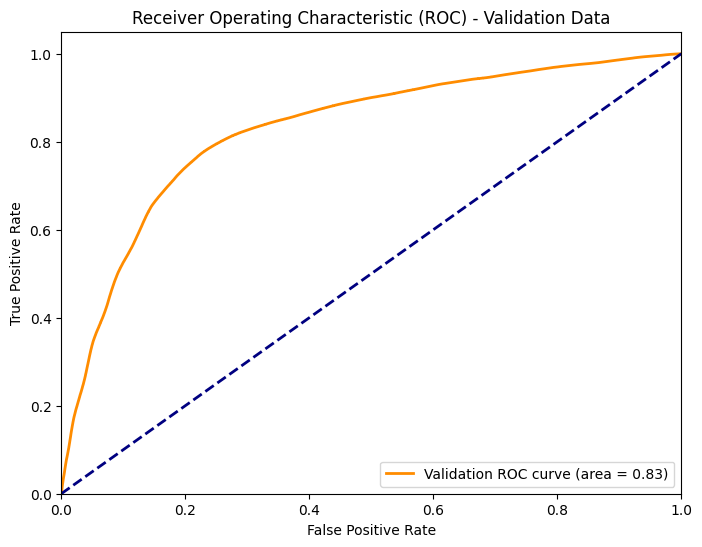

Model evaluation completed.


In [ ]:
# Define the hyperparameter grid
param_dist = [
    {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2]},
    {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga', 'lbfgs'], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2]},
    {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.1, 0.5, 0.7, 0.9], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2]},
    {'penalty': [None], 'solver': ['saga'], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2]}]

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss',
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize the Logistic Regression model
model_lr = LogisticRegression(random_state=42)

# Initialize Random Search
random_search = RandomizedSearchCV(estimator=model_lr, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Fit Random Search on the training data
random_search.fit(X_trainval_utilitarian, y_trainval_utilitarian)

# Get the best model from Random search
best_model_lr = random_search.best_estimator_
joblib.dump(best_model_lr, 'best_model_lr_utilitarian.pkl')

# Print the best model parameters
print(f"\nBest model parameters: {random_search.best_params_}\n")

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_lr = pd.DataFrame(random_search.cv_results_)
results_lr.to_csv('results_lr_utilitarian.csv', index=False)

# Compute and print the confusion matrix
y_pred_val_mlp = cross_val_predict(best_model_lr, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, method='predict')

conf_matrix = confusion_matrix(y_trainval_utilitarian, y_pred_val_mlp)
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC curve and ROC area for validation data
y_proba_val_lr = cross_val_predict(best_model_lr, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, method='predict_proba')[:, 1]

fpr_val_lr, tpr_val_lr, thresholds_val_lr = roc_curve(y_trainval_utilitarian, y_proba_val_lr)
roc_auc_val_lr = auc(fpr_val_lr, tpr_val_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_lr, tpr_val_lr, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('roc_lr_utilitarian.png')

plt.show()

print("Model evaluation completed.")

### Decision Tree

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=10; total time= 1.9min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=20; total time= 1.9min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=20; total time= 1.9min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=20; total time= 1.9min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=10; total time= 1.4min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=10; total time= 1.5min
[CV] END criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=20; total time= 1.7min
[CV] END criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=20; total time= 1.7min
[CV] END criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=20; total time= 1.7min
[CV

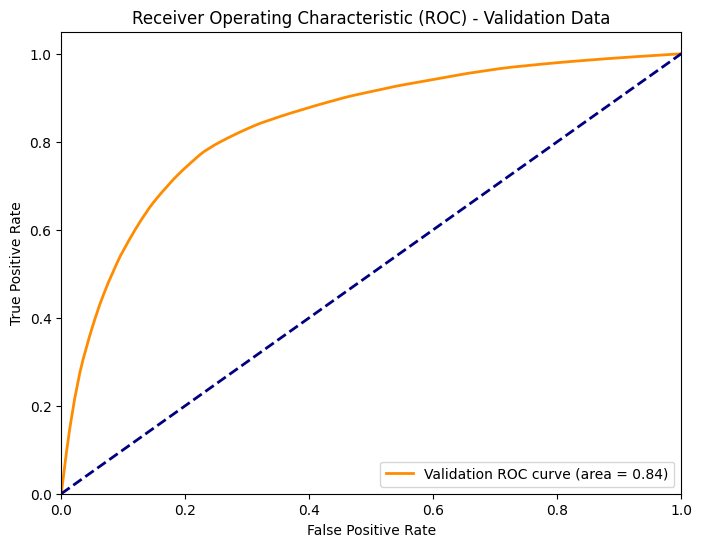

Model evaluation completed.


In [ ]:
# Define the hyperparameter grid
param_dist = {'criterion': ['gini', 'entropy'], # function to measure the quality of a split
              'max_depth': [10, 15, 20, 25, None], # maximum depth of the tree
              'min_samples_split': [10, 20, 30, 40], # minimum number of samples required to split an internal node
              'min_samples_leaf': [5, 10, 20, 30] # minimum number of samples allowed at a leaf node
}

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss',
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)

# Initialize Random Search
random_search = RandomizedSearchCV(estimator=model_dt, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Fit Random Search on the training data
random_search.fit(X_trainval_utilitarian, y_trainval_utilitarian)

# Get the best model from Random search
best_model_dt = random_search.best_estimator_
joblib.dump(best_model_dt, 'Output/best_model_dt_utilitarian.pkl')

# Print the best model parameters
print(f"\nBest model parameters: {random_search.best_params_}\n")

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_dt = pd.DataFrame(random_search.cv_results_)
results_dt.to_csv('Output/results_dt_utilitarian.csv', index=False)

# Compute and print the confusion matrix
y_pred_val_mlp = cross_val_predict(best_model_dt, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, method='predict')

conf_matrix = confusion_matrix(y_trainval_utilitarian, y_pred_val_mlp)
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC curve and ROC area for validation data
y_proba_val_dt = cross_val_predict(best_model_dt, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, method='predict_proba')[:, 1]

fpr_val_dt, tpr_val_dt, thresholds_val_dt = roc_curve(y_trainval_utilitarian, y_proba_val_dt)
roc_auc_val_dt = auc(fpr_val_dt, tpr_val_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_dt, tpr_val_dt, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_dt_utilitarian.png')

plt.show()

print("Model evaluation completed.")

### Random Forest

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best model parameters: {'n_estimators': 200, 'min_samples_split': 30, 'min_samples_leaf': 30, 'max_depth': 25, 'criterion': 'entropy'}

Training accuracy of the best model: 0.7777736266297334
Training precision of the best model: 0.7760108888705318
Training recall of the best model: 0.7809713830781847
Training f1 of the best model: 0.7784819503694499
Training AUC of the best model: 0.851225684826673

Validation accuracy of the best model: 0.7737049085250053
Validation precision of the best model: 0.7718977860376142
Validation recall of the best model: 0.7770269542383268
Validation f1 of the best model: 0.7744526104021006
Validation AUC of the best model: 0.8391329881266455

Confusion Matrix:
[[433026 129067]
 [125331 436763]]


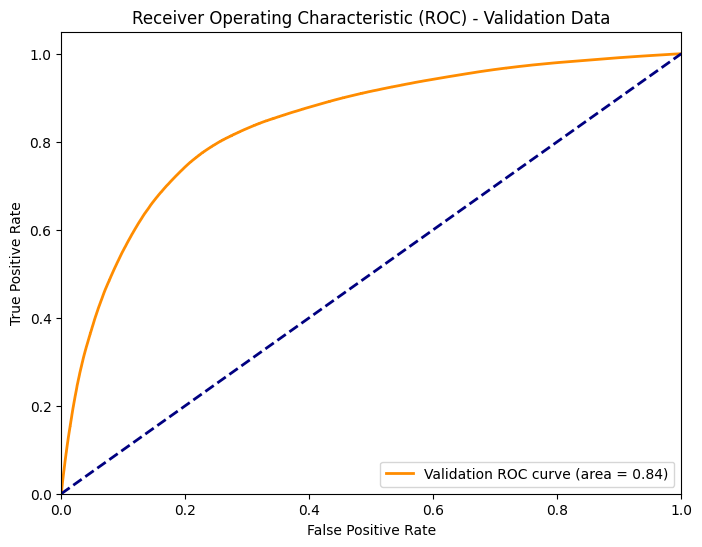

Model evaluation completed.


In [ ]:
# Define the hyperparameter grid
param_dist = {'criterion': ['gini', 'entropy'], # function to measure the quality of a split
              'max_depth': [10, 15, 20, 25, None], # maximum depth of the tree
              'min_samples_split': [20, 30, 40, 50], # minimum number of samples required to split an internal node
              'min_samples_leaf': [20, 30, 40, 50], # minimum number of samples allowed at a leaf node
              'n_estimators': [100, 150, 200, 250, 300]} # number of trees in the forest

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss',
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize Random Forest model
model_rf = RandomForestClassifier(random_state=42)

# Initialize Random Search
random_search = RandomizedSearchCV(estimator=model_rf, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Fit Random Search on the training data
random_search.fit(X_trainval_utilitarian, y_trainval_utilitarian)

# Get the best model from Random search
best_model_rf = random_search.best_estimator_
joblib.dump(best_model_rf, 'best_model_rf_utilitarian.pkl')

# Print the best model parameters
print(f"\nBest model parameters: {random_search.best_params_}\n")

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_rf = pd.DataFrame(random_search.cv_results_)
results_rf.to_csv('results_rf_utilitarian.csv', index=False)

# Compute and print the confusion matrix
y_pred_val_mlp = cross_val_predict(best_model_rf, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, method='predict')

conf_matrix = confusion_matrix(y_trainval_utilitarian, y_pred_val_mlp)
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC curve and ROC area for validation data
y_proba_val_rf = cross_val_predict(best_model_rf, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, method='predict_proba')[:, 1]

fpr_val_rf, tpr_val_rf, thresholds_val_rf = roc_curve(y_trainval_utilitarian, y_proba_val_rf)
roc_auc_val_rf = auc(fpr_val_rf, tpr_val_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_rf, tpr_val_rf, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('roc_rf_utilitarian.png')

plt.show()

print("Model evaluation completed.")

### Neural Network

In [ ]:
# Build the Neural Network model
def build_model(hidden_units, hidden_layers, activation, optimizers):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(X_trainval_utilitarian.shape[1],)))

    # Add hidden layers
    for _ in range(hidden_layers):
        model.add(layers.Dense(hidden_units))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=optimizers, loss='binary_crossentropy', metrics=['accuracy'])

    return model

[CV] END .................................................... total time= 3.3min
[CV] END .................................................... total time= 3.2min
[CV] END .................................................... total time= 3.4min
Mean training accuracy: 0.7756698841029118
Mean training precision: 0.7736353692666095
Mean training recall: 0.7793985536854972
Mean training F1: 0.7765031738725034
Mean training AUC: 0.8427942188190799
Mean validation accuracy: 0.7734033572706321
Mean validation precision: 0.7713607204459955
Mean validation recall: 0.7771689697896121
Mean validation F1: 0.7742497108337866
Mean validation AUC: 0.8388170386022223


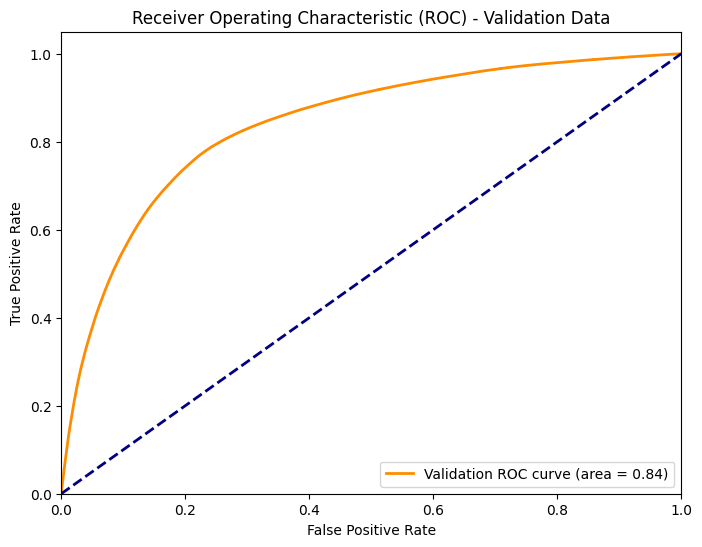

Model evaluation completed.


In [ ]:
# Fit Wiedeman 2020 on the training data
model_wiedeman = KerasClassifier(model=build_model, hidden_units=64, hidden_layers=2, activation='relu', optimizers='rmsprop', epochs=50, batch_size=10_000, verbose=0)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores = cross_validate(model_wiedeman, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, scoring=scoring, return_train_score=True, verbose=2)

print(f"Mean training accuracy: {scores['train_accuracy'].mean()}")
print(f"Mean training precision: {scores['train_precision'].mean()}")
print(f"Mean training recall: {scores['train_recall'].mean()}")
print(f"Mean training F1: {scores['train_f1'].mean()}")
print(f"Mean training AUC: {scores['train_roc_auc'].mean()}")

print(f"Mean validation accuracy: {scores['test_accuracy'].mean()}")
print(f"Mean validation precision: {scores['test_precision'].mean()}")
print(f"Mean validation recall: {scores['test_recall'].mean()}")
print(f"Mean validation F1: {scores['test_f1'].mean()}")
print(f"Mean validation AUC: {scores['test_roc_auc'].mean()}")

results_wiedeman = pd.DataFrame(scores)
results_wiedeman.to_csv('Output/results_wiedeman_utilitarian.csv', index=False)

# Compute ROC curve and ROC area for validation data
y_proba_val_wiedeman = cross_val_predict(model_wiedeman, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, method='predict_proba')[:, 1]

fpr_val_wiedeman, tpr_val_wiedeman, thresholds_val_wiedeman = roc_curve(y_trainval_utilitarian, y_proba_val_wiedeman)
roc_auc_val_wiedeman = auc(fpr_val_wiedeman, tpr_val_wiedeman)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_wiedeman, tpr_val_wiedeman, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_wiedeman:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_wiedeman_utilitarian.png')

plt.show()

print("Model evaluation completed.")

warnings.filterwarnings("ignore", category=UserWarning, message="``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best model parameters: {'model__optimizers': 'rmsprop', 'model__hidden_units': 16, 'model__hidden_layers': 3, 'model__activation': 'tanh', 'epochs': 50}

Training accuracy of the best model: 0.7746460330888011
Training precision of the best model: 0.7728542870340833
Training recall of the best model: 0.7779304537117081
Training f1 of the best model: 0.7753837704866546
Training AUC of the best model: 0.840722674487396

Validation accuracy of the best model: 0.7743062319703039
Validation precision of the best model: 0.7725233241775372
Validation recall of the best model: 0.7775757463823406
Validation f1 of the best model: 0.7750412363228482
Validation AUC of the best model: 0.8399603347155359

Confusion Matrix:
[[431315 130778]
 [123080 439014]]


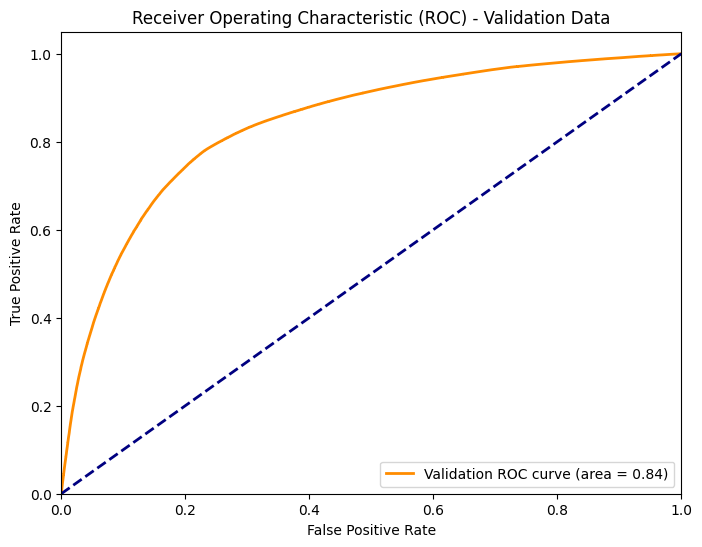

Grid search and model evaluation completed.


In [ ]:
# Initialize KerasClassifier
model_mlp = KerasClassifier(model=build_model, verbose=0)

# Define the hyperparameter grid
param_dist = {
    'model__hidden_units': [16, 32, 64, 128],              # Varying number of units in each hidden layer
    'model__hidden_layers': [1, 2, 3, 4],                  # Number of hidden layers
    'model__activation': ['relu', 'leaky_relu', 'tanh'],   # Activation functions for hidden layers
    'epochs': [10, 20, 30, 40, 50],                        # Number of training epochs
    'model__optimizers': ['adam', 'rmsprop']               # Optimizers
}

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss',
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize Random Search
random_search = RandomizedSearchCV(estimator=model_mlp, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Fit Random Search on the training data
random_search.fit(X_trainval_utilitarian, y_trainval_utilitarian, batch_size=10_000, callbacks=[early_stopping])

# Get the best model from Random search
best_model_mlp = random_search.best_estimator_
joblib.dump(best_model_mlp, 'best_model_mlp_utilitarian.pkl')

# Print the best model parameters
print(f"\nBest model parameters: {random_search.best_params_}\n")

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_mlp = pd.DataFrame(random_search.cv_results_)
results_mlp.to_csv('results_mlp_utilitarian.csv', index=False)

# Compute and print the confusion matrix
y_pred_val_mlp = cross_val_predict(best_model_mlp, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, method='predict')

conf_matrix = confusion_matrix(y_trainval_utilitarian, y_pred_val_mlp)
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC curve and ROC area for validation data
y_proba_val_mlp = cross_val_predict(best_model_mlp, X_trainval_utilitarian, y_trainval_utilitarian, cv=kf, method='predict_proba')[:, 1]

fpr_val_mlp, tpr_val_mlp, thresholds_val_mlp = roc_curve(y_trainval_utilitarian, y_proba_val_mlp)
roc_auc_val_mlp = auc(fpr_val_mlp, tpr_val_mlp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_mlp, tpr_val_mlp, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('roc_mlp_utilitarian.png')

plt.show()

print("Grid search and model evaluation completed.")

warnings.filterwarnings("ignore", category=UserWarning, message="``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.")

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7242 - loss: 0.5716 - val_accuracy: 0.7702 - val_loss: 0.5241
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7704 - loss: 0.5190 - val_accuracy: 0.7712 - val_loss: 0.5141
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7723 - loss: 0.5116 - val_accuracy: 0.7719 - val_loss: 0.5105
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7735 - loss: 0.5079 - val_accuracy: 0.7729 - val_loss: 0.5073
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7730 - loss: 0.5060 - val_accuracy: 0.7731 - val_loss: 0.5045
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7740 - loss: 0.5031 - val_accuracy: 0.7732 - val_loss: 0.5024
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7734 - loss: 0.5019 - val_accuracy: 0.7736 - val_loss: 0.5006
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7746 - loss: 0.4990 - val_accuracy: 0.7737 - val_loss

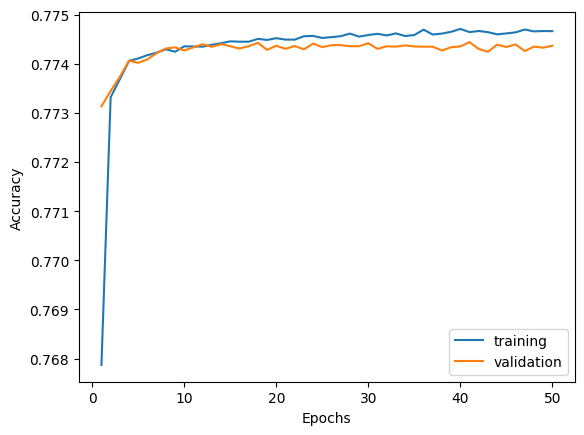

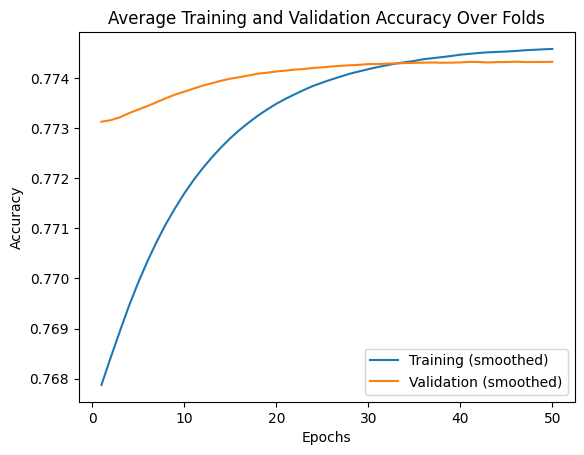

In [ ]:
# Plot the learning curve
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

best_model = build_model(hidden_layers=3,hidden_units=16,activation='tanh',optimizers='rmsprop')

# Store histories of each fold
train_histories = []
val_histories = []

for train_index, val_index in kf.split(X_trainval_utilitarian, y_trainval_utilitarian):
    X_train_fold, X_val_fold = X_trainval_utilitarian.iloc[train_index], X_trainval_utilitarian.iloc[val_index]
    y_train_fold, y_val_fold = y_trainval_utilitarian[train_index], y_trainval_utilitarian[val_index]

    # Train the model for the current fold
    history = best_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, batch_size=10_000)

    # Collect the accuracy history
    train_histories.append(history.history['accuracy'])
    val_histories.append(history.history['val_accuracy'])

# Calculate the average history for training and validation
train_histories = np.array(train_histories)
val_histories = np.array(val_histories)

avg_train_history = np.mean(train_histories, axis=0)
avg_val_history = np.mean(val_histories, axis=0)

# Smooth the averaged curves
smooth_avg_train_history = smooth_curve(avg_train_history)
smooth_avg_val_history = smooth_curve(avg_val_history)

# Plot the average training and validation histories
plt.plot(range(1, len(avg_train_history) + 1), avg_train_history)
plt.plot(range(1, len(avg_val_history) + 1), avg_val_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])

plt.savefig('learning_curve_utilitarian.png')

plt.show()

# Plot the smoothed average training and validation histories
plt.plot(range(1, len(smooth_avg_train_history) + 1), smooth_avg_train_history)
plt.plot(range(1, len(smooth_avg_val_history) + 1), smooth_avg_val_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training (smoothed)', 'Validation (smoothed)'])
plt.title('Average Training and Validation Accuracy Over Folds')

plt.savefig('learning_curve_smoothed_utilitarian.png')

plt.show()

## Test Best Model on Test Set

Training Set Performance:
Accuracy: 0.7746122308832961
Precision: 0.7746270698518987
Recall: 0.7746122308832961
F1 Score: 0.7746091851994812
Confusion Matrix: 
[[437471 124623]
 [128755 433338]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.77      0.77    562093
           1       0.77      0.78      0.78    562094

    accuracy                           0.77   1124187
   macro avg       0.77      0.77      0.77   1124187
weighted avg       0.77      0.77      0.77   1124187

Test Set Performance:
Accuracy: 0.7747280703939199
Precision: 0.7747377988956713
Recall: 0.7747280703939199
F1 Score: 0.7747260795108295
Confusion Matrix: 
[[109285  31238]
 [ 32074 108450]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.77      0.77    140524
           1       0.77      0.78      0.78    140523

    accuracy                           0.77    281047
   macro avg       0.

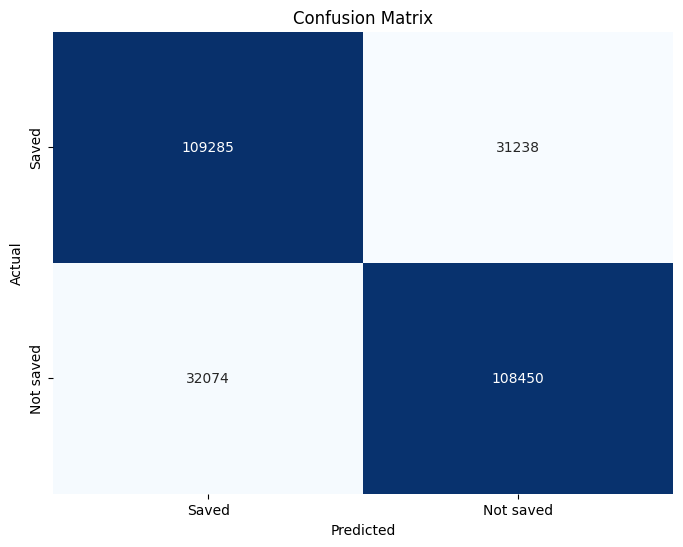

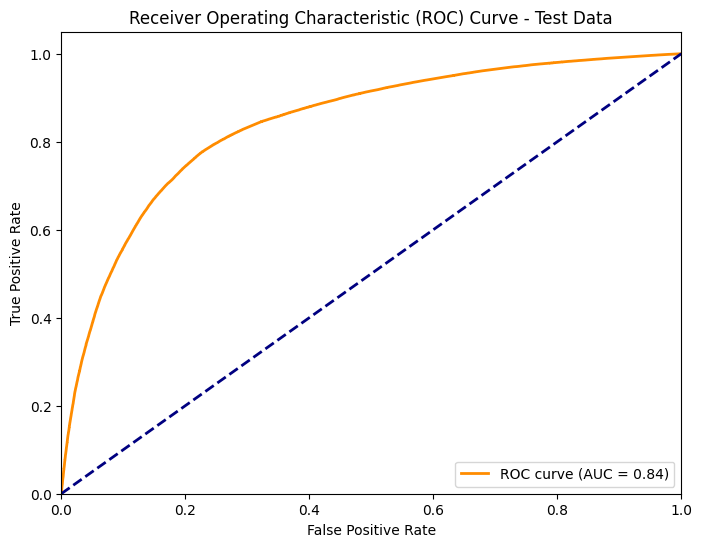

In [ ]:
# Load the best model from the .pkl file
best_model_mlp_utilitarian = joblib.load('Output/best_model_mlp_utilitarian.pkl')

# Evaluate the best model on the test data
y_pred = best_model_mlp_utilitarian.predict(X_test_utilitarian)
y_pred_train = best_model_mlp_utilitarian.predict(X_trainval_utilitarian)

# Compute the evaluation metrics
train_accuracy = accuracy_score(y_trainval_utilitarian, y_pred_train)
train_precision = precision_score(y_trainval_utilitarian, y_pred_train, average='weighted')
train_recall = recall_score(y_trainval_utilitarian, y_pred_train, average='weighted')
train_f1 = f1_score(y_trainval_utilitarian, y_pred_train, average='weighted')
train_conf_matrix = confusion_matrix(y_trainval_utilitarian, y_pred_train)[::-1, ::-1]
train_class_report = classification_report(y_trainval_utilitarian, y_pred_train)

accuracy = accuracy_score(y_test_utilitarian, y_pred)
precision = precision_score(y_test_utilitarian, y_pred, average='weighted')
recall = recall_score(y_test_utilitarian, y_pred, average='weighted')
f1 = f1_score(y_test_utilitarian, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_utilitarian, y_pred)[::-1, ::-1]
class_report = classification_report(y_test_utilitarian, y_pred)

# Print the results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print(f"Confusion Matrix: \n{train_conf_matrix}")
print(f"Classification Report: \n{train_class_report}")

print("Test Set Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Classification Report: \n{class_report}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Saved', 'Not saved'], yticklabels=['Saved', 'Not saved'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and ROC area for test data
y_prob = best_model_mlp_utilitarian.predict_proba(X_test_utilitarian)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_utilitarian, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc='lower right')
plt.show()

## Feature Importance

In [ ]:
X_test_utilitarian.head()

,PedPed,Barrier,NumberOfCharacters,DiffNumberOFCharacters,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,NumberOfLivesSaved,Finance_nols,ICT_nols,Industry_nols,Overall_nols,Research_nols,Skills_nols,Total_nols,Males_nols,Females_nols,Passengers_nols,Pedestrians_nols,AttributeLevel_More,CrossingSignal_1,CrossingSignal_2,Clusters_1,Clusters_2,Clusters_3,Clusters_4,Clusters_5
0,1,0,0.845076,0.445311,-0.4374,-0.436605,-0.437006,1.891734,-0.436789,-0.437596,-0.437237,1.891694,-0.437297,-0.437018,-0.436861,1.892292,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,-0.436645,1.899310,1.895486,0.807870,-0.203868,0.065141,1.001200,1.240846,0.192654,0.682665,0.514950,1.143918,0.438905,0.285340,1.094411,1.196693,1.035579,1.095853,1.252427,1.429078,1.114207,1.320638,1.228900,1.550156,1.194413,1.082577,1,0,0,0,1,0,0,0
1,1,0,0.845076,1.339690,-0.4374,-0.436605,1.899433,-0.437964,-0.436789,-0.437596,-0.437237,1.891694,-0.437297,-0.437018,1.893286,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,1.901005,1.894372,-0.438072,-0.438222,0.807870,0.996578,0.065141,0.269309,-0.168385,0.192654,-0.632046,-0.675336,-0.457628,0.293474,-0.702728,1.459301,1.595665,1.699512,1.461203,1.502944,1.333801,1.485694,0.816940,0.748018,0.983487,1.499766,0.644650,1,1,0,0,0,0,0,0
2,1,0,-1.857660,1.339690,-0.4374,-0.436605,-0.437006,-0.437964,-0.436789,-0.437596,-0.437237,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,-0.437169,-0.438582,1.89596,-0.437544,-0.436515,-0.436645,-0.438072,-0.438222,-0.161656,0.996578,1.257895,0.269309,0.301359,0.192654,-0.946007,-0.896214,-1.005525,-0.851211,-0.946646,-1.459817,-1.418785,-1.699823,-1.644268,-1.503260,-1.524510,-1.486208,-0.592006,-0.583303,-0.613165,-0.769298,-0.447910,0,1,0,0,0,1,0,0
3,1,0,-0.506292,-0.449067,-0.4374,-0.436605,-0.437006,-0.437964,-0.436789,-0.437596,-0.437237,-0.437748,1.900932,-0.437018,1.893286,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,-0.436645,1.899310,-0.438222,-0.161656,0.996578,1.257895,0.269309,0.301359,0.192654,-0.946007,-0.896214,-1.005525,-0.851211,-0.946646,-0.730037,-0.709503,-0.849989,-0.822232,-0.751709,-0.762294,-0.743232,-0.296128,-0.291790,-0.306665,-0.384779,-0.224073,0,1,0,0,0,1,0,0
4,0,0,-1.857660,1.339690,-0.4374,-0.436605,-0.437006,-0.437964,-0.436789,-0.437596,-0.437237,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,-0.437169,-0.438582,-0.43736,1.897662,-0.436515,-0.436645,-0.438072,-0.438222,0.807870,0.996578,0.065141,0.269309,0.066487,1.004511,-1.191289,-1.110956,-1.300547,-1.328005,-0.857077,-1.459817,-1.596105,-1.699823,-1.461594,-1.503260,-1.429233,-1.684335,-0.415888,-0.422626,-0.413584,-0.464821,-0.520328,0,0,0,0,0,1,0,0


In [ ]:
# Compute permutation importance
result_utilitarian = permutation_importance(best_model_mlp_utilitarian, X_test_utilitarian, y_test_utilitarian, n_repeats=1, random_state=42)
joblib.dump(result_utilitarian, 'result_permutation_utilitarian.pkl')

['result_permutation_utilitarian.pkl']

In [36]:
# Load in the training and test datasets
X_trainval = pd.read_csv('Data/X_trainval.csv')
y_trainval = pd.read_csv('Data/y_trainval.csv').values.ravel() # ravel to convert to 1D array
X_test = pd.read_csv('Data/X_test.csv')
y_test = pd.read_csv('Data/y_test.csv').values.ravel() # ravel to convert to 1D array

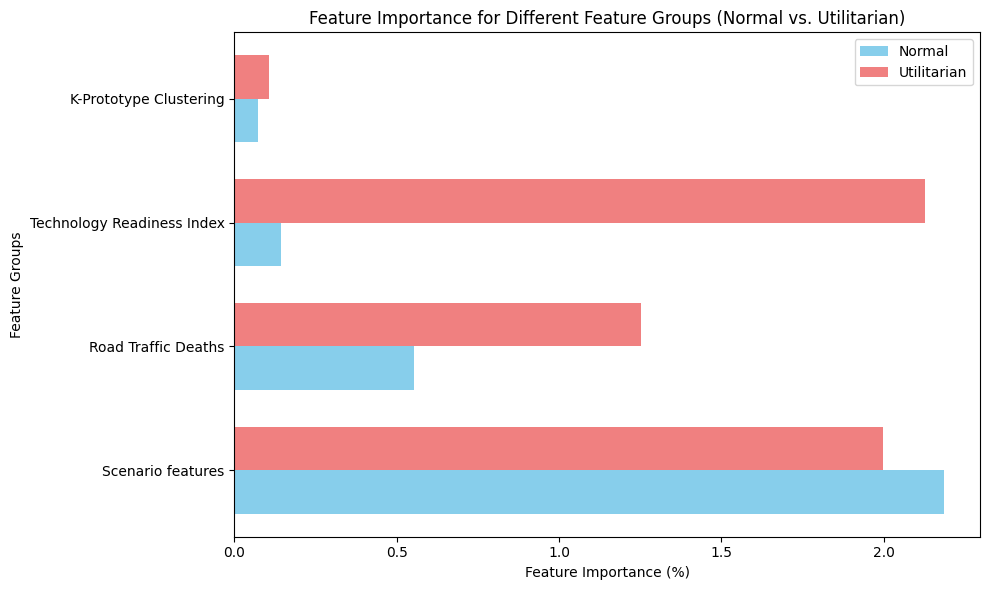

In [ ]:
result = joblib.load('Output/result_permutation.pkl')
result_utilitarian = joblib.load('Output/result_permutation_utilitarian.pkl')

all_indices = range(len(X_trainval.columns))
all_indices_utilitarian = range(len(X_trainval_utilitarian.columns))

all_feature_importances = result.importances_mean[all_indices]
all_feature_importances_utilitarian = result_utilitarian.importances_mean[all_indices_utilitarian]

total_importance = all_feature_importances.sum()
total_importance_utilitarian = all_feature_importances_utilitarian.sum()

importance_percentages = (all_feature_importances / total_importance) * 100
importance_percentages_utilitarian = (all_feature_importances_utilitarian / total_importance_utilitarian) * 100

# Scenario feature importance
scenario_features = ['PedPed', 'Barrier', 'NumberOfCharacters', 'DiffNumberOFCharacters', 'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'AttributeLevel_Female', 'AttributeLevel_Fit', 'AttributeLevel_High', 'AttributeLevel_Hoomans', 'AttributeLevel_Less', 'AttributeLevel_Low', 'AttributeLevel_Male', 'AttributeLevel_More', 'AttributeLevel_Old', 'AttributeLevel_Pets', 'AttributeLevel_Rand', 'AttributeLevel_Young', 'ScenarioTypeStrict_Fitness', 'ScenarioTypeStrict_Gender', 'ScenarioTypeStrict_Random', 'ScenarioTypeStrict_Social Status', 'ScenarioTypeStrict_Species', 'ScenarioTypeStrict_Utilitarian', 'CrossingSignal_1', 'CrossingSignal_2']
scenario_indices = [X_trainval.columns.get_loc(feature) for feature in scenario_features]
scenario_importance_percentages = importance_percentages[scenario_indices]
scenario_feature_importance = scenario_importance_percentages.mean()

# Availibility bias road traffic deaths feature importance
road_traffic_features = ['Total', 'Males', 'Females', 'Passengers', 'Pedestrians']
road_traffic_indices = [X_trainval.columns.get_loc(feature) for feature in road_traffic_features]
road_traffic_importance_percentages = importance_percentages[road_traffic_indices]
road_traffic_feature_importance = road_traffic_importance_percentages.mean()

# Availibility bias technology readiness index feature importance
technology_readiness_features = ['Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills']
technology_readiness_indices = [X_trainval.columns.get_loc(feature) for feature in technology_readiness_features]
technology_readiness_importance_percentages = importance_percentages[technology_readiness_indices]
technology_readiness_feature_importance = technology_readiness_importance_percentages.mean()

# K-protoype clustering feature importance
k_prototype_features = ['Clusters_1', 'Clusters_2']
k_prototype_indices = [X_trainval.columns.get_loc(feature) for feature in k_prototype_features]
k_prototype_importance_percentages = importance_percentages[k_prototype_indices]
k_prototype_feature_importance = k_prototype_importance_percentages.mean()

########################################################################################################################################

# Scenario feature importance for the utilitarian model
scenario_features_utilitarian = ['PedPed', 'Barrier', 'NumberOfCharacters', 'DiffNumberOFCharacters', 'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'NumberOfLivesSaved', 'AttributeLevel_More', 'CrossingSignal_1', 'CrossingSignal_2', 'Clusters_1', 'Clusters_2', 'Clusters_3']
scenario_indices_utilitarian = [X_trainval_utilitarian.columns.get_loc(feature) for feature in scenario_features_utilitarian]
scenario_importance_percentages_utilitarian = importance_percentages_utilitarian[scenario_indices_utilitarian]
scenario_feature_importance_utilitarian = scenario_importance_percentages_utilitarian.mean()

# Availibility bias road traffic deaths feature importance for the utilitarian model
road_traffic_features_utilitarian = ['Total', 'Males', 'Females', 'Passengers', 'Pedestrians', 'Total_nols', 'Males_nols', 'Females_nols', 'Passengers_nols', 'Pedestrians_nols']
road_traffic_indices_utilitarian = [X_trainval_utilitarian.columns.get_loc(feature) for feature in road_traffic_features_utilitarian]
road_traffic_importance_percentages_utilitarian = importance_percentages_utilitarian[road_traffic_indices_utilitarian]
road_traffic_feature_importance_utilitarian = road_traffic_importance_percentages_utilitarian.mean()

# Availibility bias technology readiness index feature importance for the utilitarian model
technology_readiness_features_utilitarian = ['Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills', 'Finance_nols', 'ICT_nols', 'Industry_nols', 'Overall_nols', 'Research_nols', 'Skills_nols']
technology_readiness_indices_utilitarian = [X_trainval_utilitarian.columns.get_loc(feature) for feature in technology_readiness_features_utilitarian]
technology_readiness_importance_percentages_utilitarian = importance_percentages_utilitarian[technology_readiness_indices_utilitarian]
technology_readiness_feature_importance_utilitarian = technology_readiness_importance_percentages_utilitarian.mean()

# K-protoype clustering feature importance for the utilitarian model
k_prototype_features_utilitarian = ['Clusters_1', 'Clusters_2', 'Clusters_3', 'Clusters_4', 'Clusters_5']
k_prototype_indices_utilitarian = [X_trainval_utilitarian.columns.get_loc(feature) for feature in k_prototype_features_utilitarian]
k_prototype_importance_percentages_utilitarian = importance_percentages_utilitarian[k_prototype_indices_utilitarian]
k_prototype_feature_importance_utilitarian = k_prototype_importance_percentages_utilitarian.mean()

########################################################################################################################################

# Define data
group_names = ['Scenario features', 'Road Traffic Deaths', 'Technology Readiness Index', 'K-Prototype Clustering']
normal_importances = [scenario_feature_importance, road_traffic_feature_importance, technology_readiness_feature_importance, k_prototype_feature_importance]
utilitarian_importances = [scenario_feature_importance_utilitarian, road_traffic_feature_importance_utilitarian, technology_readiness_feature_importance_utilitarian, k_prototype_feature_importance_utilitarian]

# Sort the bars based on normalized normal importance (blue bars)
sorted_indices = np.argsort(normal_importances)  # Reverse the sort for longest to shortest
sorted_group_names = [group_names[i] for i in sorted_indices]
sorted_normal_importances = [normal_importances[i] for i in sorted_indices]
sorted_utilitarian_importances = [utilitarian_importances[i] for i in sorted_indices]

# Create bar positions
y = np.arange(len(sorted_group_names))  # The label locations
height = 0.35  # The height of the bars

# Plot the feature importances
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.barh(y + height/2, sorted_normal_importances, height, label='Normal', color='skyblue')
bars2 = ax.barh(y - height/2, sorted_utilitarian_importances, height, label='Utilitarian', color='lightcoral')
ax.set_ylabel('Feature Groups')
ax.set_xlabel('Feature Importance (%)')
ax.set_title('Feature Importance for Different Feature Groups (Normal vs. Utilitarian)')
ax.set_yticks(y)
ax.set_yticklabels(sorted_group_names)
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()


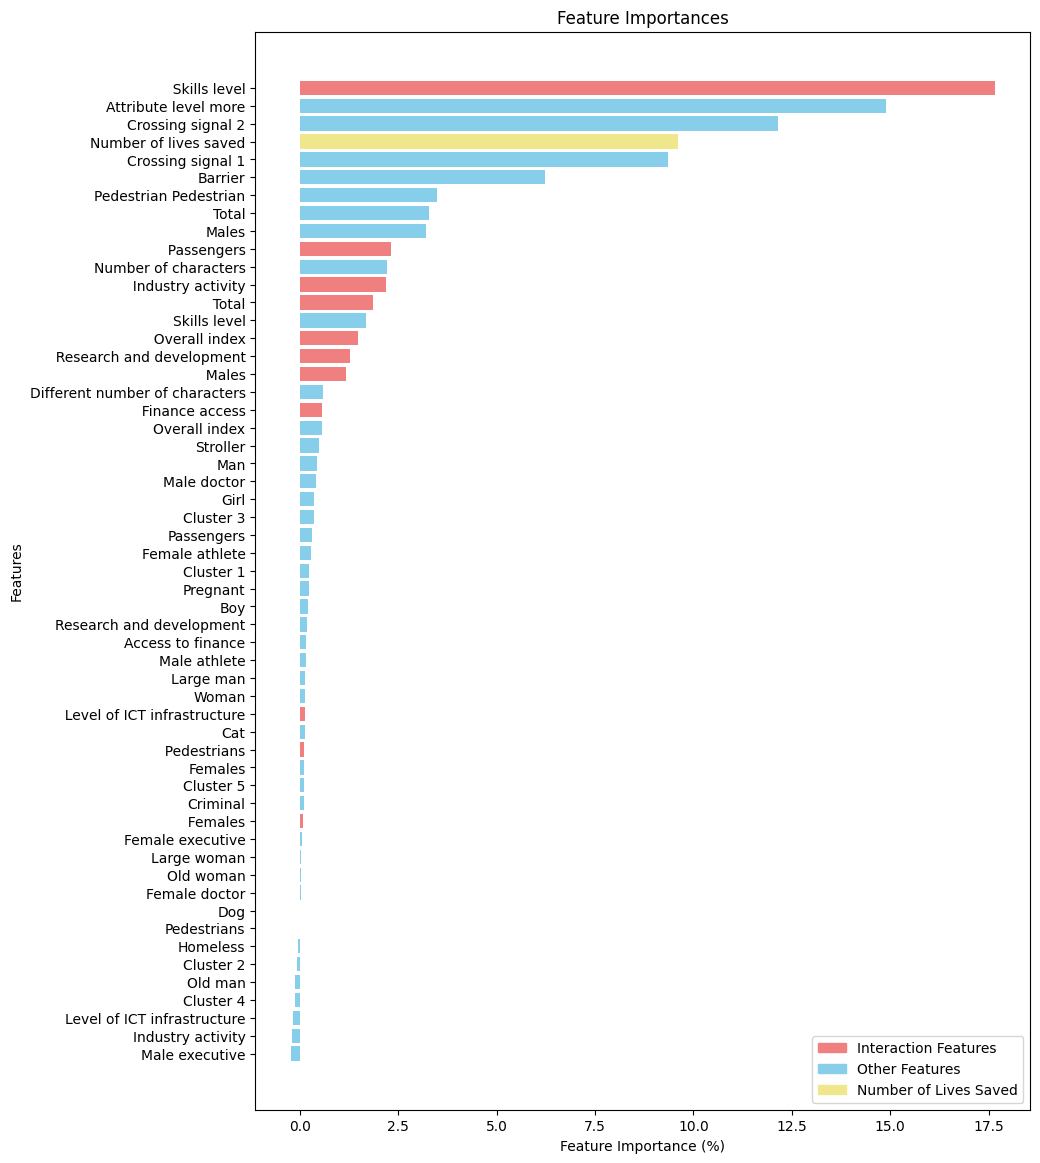

In [ ]:
# Plot all feature importances in the "utilitarian" dataset
feature_names = X_trainval_utilitarian.columns.tolist()
selected_indices = list(range(len(feature_names)))

feature_importances = importance_percentages_utilitarian[selected_indices]

# Sort the feature importances and names in descending order
sorted_indices = np.argsort(feature_importances)[::-1]  # Get indices for descending order
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

colors = ['khaki' if name == 'NumberOfLivesSaved' else 'lightcoral' if '_nols' in name else 'skyblue' for name in sorted_feature_names]

# Define color categories and labels
color_labels = {'lightcoral': 'Interaction Features', 'skyblue': 'Other Features', 'khaki': 'Number of Lives Saved'}

# Rename the feature names for better visualization
ordered_feature_names = ["  Skills level","Attribute level more","Crossing signal 2","Number of lives saved",  "Crossing signal 1", "Barrier", "Pedestrian Pedestrian","Total", "Males","  Passengers",  "Number of characters", "  Industry activity","  Total", "Skills level", "  Overall index","  Research and development", "  Males","Different number of characters", "  Finance access","Overall index", "Stroller","Man", "Male doctor","Girl","Cluster 3","Passengers", "Female athlete","Cluster 1","Pregnant","Boy","Research and development", "Access to finance","Male athlete","Large man", "Woman", "  Level of ICT infrastructure", "Cat","  Pedestrians", "Females","Cluster 5","Criminal", "  Females","Female executive","Large woman", "Old woman","Female doctor", "Dog","Pedestrians","Homeless","Cluster 2", "Old man","Cluster 4","Level of ICT infrastructure", "Industry activity","Male executive"]

# Plot the feature importances with updated feature names
plt.figure(figsize=(10, 14))
plt.barh(ordered_feature_names, sorted_feature_importances, color=colors)
plt.xlabel("Feature Importance (%)")
plt.ylabel("Features")
plt.title(f"Feature Importances")

# Create legend entries and add to the plot
patches_list = [patches.Patch(color=color, label=label) for color, label in color_labels.items()]
plt.legend(handles=patches_list)

# Invert y-axis to show the most important feature at the top
plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Create a DataFrame with feature names and their importance and relative importance
importance_df = pd.DataFrame({'Feature': X_test_utilitarian.columns, 'Importance': result_utilitarian.importances_mean})

importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

total_importance = importance_df['Importance'].sum()
importance_df['Relative Importance (%)'] = (importance_df['Importance'] / total_importance) * 100

importance_df

,Feature,Importance,Relative Importance (%)
0,Skills_nols,0.010827,17.662081
1,AttributeLevel_More,0.009123,14.881885
2,CrossingSignal_2,0.007447,12.148122
3,NumberOfLivesSaved,0.005885,9.600093
4,CrossingSignal_1,0.005743,9.367926
5,Barrier,0.003821,6.233676
6,PedPed,0.002138,3.488305
7,Total,0.002010,3.279355
8,Males,0.001968,3.209705
9,Passengers_nols,0.001427,2.327471


## Partial Dependence Plot

In [ ]:
X_test_utilitarian.head()

,PedPed,Barrier,NumberOfCharacters,DiffNumberOFCharacters,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,NumberOfLivesSaved,Finance_nols,ICT_nols,Industry_nols,Overall_nols,Research_nols,Skills_nols,Total_nols,Males_nols,Females_nols,Passengers_nols,Pedestrians_nols,AttributeLevel_More,CrossingSignal_1,CrossingSignal_2,Clusters_1,Clusters_2,Clusters_3,Clusters_4,Clusters_5
0,1,0,0.845076,0.445311,-0.4374,-0.436605,-0.437006,1.891734,-0.436789,-0.437596,-0.437237,1.891694,-0.437297,-0.437018,-0.436861,1.892292,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,-0.436645,1.899310,1.895486,0.807870,-0.203868,0.065141,1.001200,1.240846,0.192654,0.682665,0.514950,1.143918,0.438905,0.285340,1.094411,1.196693,1.035579,1.095853,1.252427,1.429078,1.114207,1.320638,1.228900,1.550156,1.194413,1.082577,1,0,0,0,1,0,0,0
1,1,0,0.845076,1.339690,-0.4374,-0.436605,1.899433,-0.437964,-0.436789,-0.437596,-0.437237,1.891694,-0.437297,-0.437018,1.893286,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,1.901005,1.894372,-0.438072,-0.438222,0.807870,0.996578,0.065141,0.269309,-0.168385,0.192654,-0.632046,-0.675336,-0.457628,0.293474,-0.702728,1.459301,1.595665,1.699512,1.461203,1.502944,1.333801,1.485694,0.816940,0.748018,0.983487,1.499766,0.644650,1,1,0,0,0,0,0,0
2,1,0,-1.857660,1.339690,-0.4374,-0.436605,-0.437006,-0.437964,-0.436789,-0.437596,-0.437237,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,-0.437169,-0.438582,1.89596,-0.437544,-0.436515,-0.436645,-0.438072,-0.438222,-0.161656,0.996578,1.257895,0.269309,0.301359,0.192654,-0.946007,-0.896214,-1.005525,-0.851211,-0.946646,-1.459817,-1.418785,-1.699823,-1.644268,-1.503260,-1.524510,-1.486208,-0.592006,-0.583303,-0.613165,-0.769298,-0.447910,0,1,0,0,0,1,0,0
3,1,0,-0.506292,-0.449067,-0.4374,-0.436605,-0.437006,-0.437964,-0.436789,-0.437596,-0.437237,-0.437748,1.900932,-0.437018,1.893286,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,-0.436645,1.899310,-0.438222,-0.161656,0.996578,1.257895,0.269309,0.301359,0.192654,-0.946007,-0.896214,-1.005525,-0.851211,-0.946646,-0.730037,-0.709503,-0.849989,-0.822232,-0.751709,-0.762294,-0.743232,-0.296128,-0.291790,-0.306665,-0.384779,-0.224073,0,1,0,0,0,1,0,0
4,0,0,-1.857660,1.339690,-0.4374,-0.436605,-0.437006,-0.437964,-0.436789,-0.437596,-0.437237,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,-0.437169,-0.438582,-0.43736,1.897662,-0.436515,-0.436645,-0.438072,-0.438222,0.807870,0.996578,0.065141,0.269309,0.066487,1.004511,-1.191289,-1.110956,-1.300547,-1.328005,-0.857077,-1.459817,-1.596105,-1.699823,-1.461594,-1.503260,-1.429233,-1.684335,-0.415888,-0.422626,-0.413584,-0.464821,-0.520328,0,0,0,0,0,1,0,0


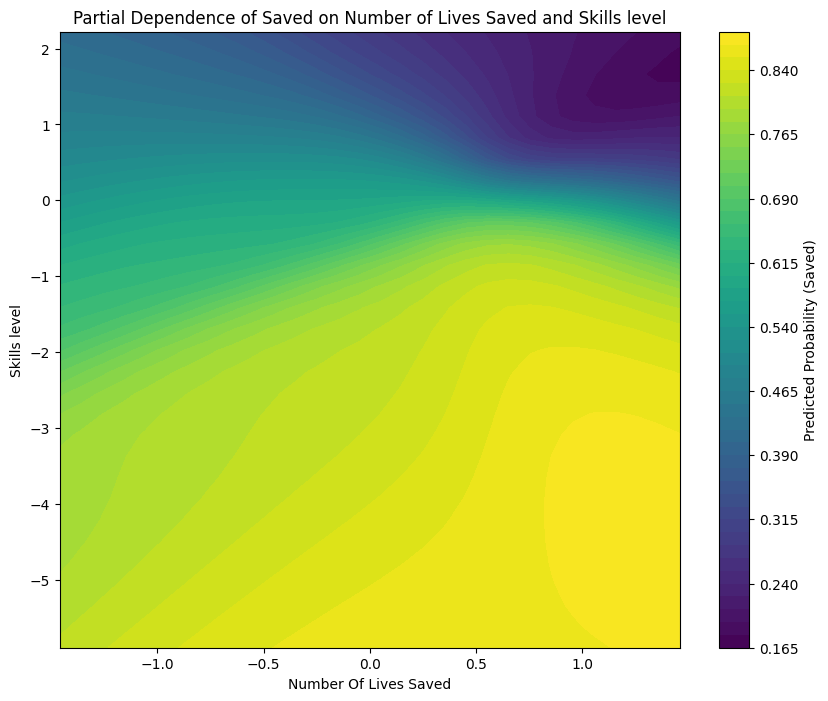

In [ ]:
# Craete a partial dependence plot for the two most important interaction features
# Generate a grid of values for the two features
number_of_lives_saved_values = np.linspace(
    X_test_utilitarian['NumberOfLivesSaved'].min(),
    X_test_utilitarian['NumberOfLivesSaved'].max(),
    30  
)

skills_values = np.linspace(
    X_test_utilitarian['Skills'].min(),
    X_test_utilitarian['Skills'].max(),
    30 
)

# Create a meshgrid
X_grid, Y_grid = np.meshgrid(number_of_lives_saved_values, skills_values)

# Flatten the grid to generate a dataset for predictions
grid_data = pd.DataFrame({
    'NumberOfLivesSaved': X_grid.ravel(),
    'Skills': Y_grid.ravel()
})

# Fix other feature values by averaging them
for col in X_test_utilitarian.columns:
    if col not in ['NumberOfLivesSaved', 'Skills']:
        grid_data[col] = X_test_utilitarian[col].mean()

# Generate predictions for the grid
grid_predictions = best_model_mlp_utilitarian.predict_proba(grid_data)[:, 1]  # Use the probability of the positive class (Saved)

# Reshape predictions to match the grid
Z_grid = grid_predictions.reshape(X_grid.shape)

# Plot the heatmap
plt.figure(figsize=(10, 8))
contour = plt.contourf(X_grid, Y_grid, Z_grid, cmap='viridis', levels=50)
plt.colorbar(contour, label='Predicted Probability (Saved)')
plt.xlabel('Number Of Lives Saved (Normalized)')
plt.ylabel('Skills level (Normalized)')
plt.title('Partial Dependence of Saved on Number of Lives Saved and Skills level')
plt.show()


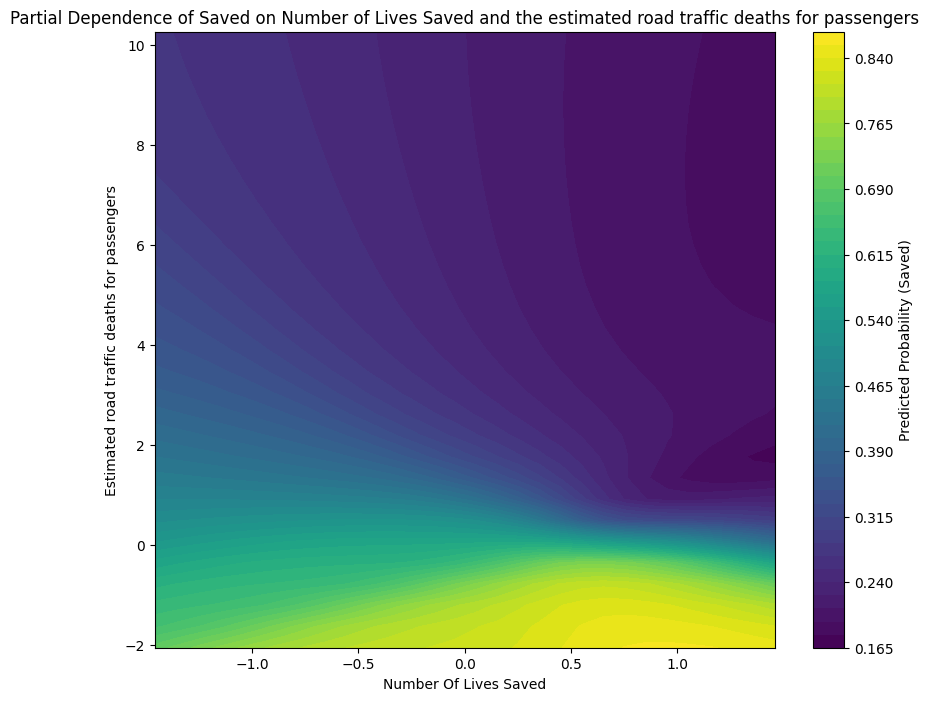

In [ ]:
# Craete a partial dependence plot for the two most important interaction features
# Generate a grid of values for the two features
number_of_lives_saved_values = np.linspace(
    X_test_utilitarian['NumberOfLivesSaved'].min(),
    X_test_utilitarian['NumberOfLivesSaved'].max(),
    30  
)

passenger_values = np.linspace(
    X_test_utilitarian['Passengers'].min(),
    X_test_utilitarian['Passengers'].max(),
    30  
)

# Create a meshgrid
X_grid, Y_grid = np.meshgrid(number_of_lives_saved_values, passenger_values)

# Flatten the grid to generate a dataset for predictions
grid_data = pd.DataFrame({
    'NumberOfLivesSaved': X_grid.ravel(),
    'Passengers': Y_grid.ravel()
})

# Fix other feature values by averaging them
for col in X_test_utilitarian.columns:
    if col not in ['NumberOfLivesSaved', 'Passengers']:
        grid_data[col] = X_test_utilitarian[col].mean()

# Generate predictions for the grid
grid_predictions = best_model_mlp_utilitarian.predict_proba(grid_data)[:, 1]  # Use the probability of the positive class (Saved)

# Reshape predictions to match the grid
Z_grid = grid_predictions.reshape(X_grid.shape)

# Plot the heatmap
plt.figure(figsize=(10, 8))
contour = plt.contourf(X_grid, Y_grid, Z_grid, cmap='viridis', levels=50)
plt.colorbar(contour, label='Predicted Probability (Saved)')
plt.xlabel('Number Of Lives Saved (Normalized)')
plt.ylabel('Estimated road traffic deaths for passengers (Normalized)')
plt.title('Partial Dependence of Saved on Number of Lives Saved and the estimated road traffic deaths for passengers')
plt.show()
